# Gradient Boosting Decision Trees

Here, we explore the suitability of using a Gradient Boosting Decision Tree on the dataset as well as gain a deeper understanding of how the different libraries compare to each other. We will be fitting the dataset on a XGBoost, LightGBM and CatBoost Model. 

Parameter Tuning is done as well.
Current progress: XGBoost completed, LightGBM & CatBoost WIP.

Data Source: https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as se

%matplotlib inline

In [2]:
df_train = pd.read_csv('df_train.csv')

In [3]:
df_train = df_train.drop('Unnamed: 0', axis = 1).set_index('Id').drop(1, axis = 0)
df_train.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
Id,,,,,,,,,,,,,,,,,,,,,
2,4.110874,9.042040,6,1.791759,7.602900,7.602900,6.561031,0.0,5.017280,6.753438,...,0,0,0,1,0,0,0,0,1,0
3,3.044522,9.169623,7,2.197225,7.589336,7.589336,6.886532,0.0,5.652489,7.141245,...,0,0,0,1,0,0,0,0,1,0
4,4.110874,9.328212,7,1.791759,7.601902,7.602401,6.188264,0.0,6.075346,6.825460,...,0,0,0,1,1,0,0,0,0,0
5,4.262680,9.164401,8,1.791759,7.557995,7.586296,5.379897,0.0,6.293419,6.629363,...,0,0,0,1,0,0,0,0,1,0
6,4.110874,9.565284,5,1.791759,7.601402,7.601402,6.486161,0.0,6.196444,7.044033,...,0,0,0,1,0,0,0,0,1,0


## Preparing data

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [5]:
df_num = pd.read_csv('df_num.csv')
df_num = df_num.set_index('Id')
scaler = StandardScaler()
df_train[df_num.columns] = scaler.fit_transform(df_train[df_num.columns])

C:\Users\Chua\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\Chua\Anaconda3\lib\site-packages\sklearn\base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [6]:
x_train, x_test, y_train, y_test = train_test_split(df_train.drop('SalePrice', axis=1), df_train['SalePrice'], test_size = 0.3)

## XGBoost

In [7]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from math import sqrt

In [8]:
dtrain = xgb.DMatrix(x_train, label = y_train)
dtest = xgb.DMatrix(x_test)

C:\Users\Chua\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Firstly, we fix the learning rate and tune the n-estimator (number of trees).

In [9]:
xgb_model = xgb.XGBRegressor(eta= 0.1, max_depth = 5, min_child_weight = 1, gamma = 0, subsample = 0.8, colsample_bytree = 0.8,
                            scale_pos_weight = 1, seed = 2019, objective = 'reg:squarederror')

In [96]:
def xgb_nestopt(model, df_train, num_boost = 500, cv=5, esr=50):
    
    params_temp = model.get_xgb_params()
    xgb_cv = xgb.cv(model.get_xgb_params(), df_train, num_boost_round=num_boost, early_stopping_rounds=esr, nfold=cv)
    xgb_cv.loc[:,['train-rmse-mean', 'test-rmse-mean']].plot()
    model.set_params(n_estimators=xgb_cv.shape[0])
    score(model, x_test)
    print('Best Iteration:', xgb_cv.shape[0])
    print(xgb_cv.iloc[-1])

prev_score = {'RMSE': 1e10, 'R_squared': 0}

def score(model, df_test):
    model.fit(x_train, y_train)
    model_pred = model.predict(x_test)
    rmse_temp = sqrt(mean_squared_error(model_pred, y_test))
    r2_temp = np.corrcoef(model_pred, y_test)[0][1]**2
    
    print('Previous RMSE:', prev_score['RMSE'], 'vs. New RMSE:', rmse_temp)
    print('Previous R-squared value:', prev_score['R_squared'], 'vs. R-squared value:', r2_temp)
    
    if rmse_temp > prev_score['RMSE']:
        print('New model has a higher RMSE than the previous')
    
    prev_score['RMSE'] = rmse_temp
    prev_score['R_squared'] = r2_temp

C:\Users\Chua\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Current RMSE: 10000000000.0 vs. New RMSE: 0.36372930784027924
Current RMSE: 10000000000.0 vs. New RMSE: 0.36372930784027924
R-squared value: 0.8757305706933509
Best Iteration: 68
train-rmse-mean    0.147538
train-rmse-std     0.005449
test-rmse-mean     0.382086
test-rmse-std      0.059006
Name: 67, dtype: float64


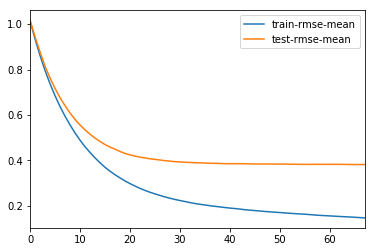

In [21]:
xgb_nestopt(xgb_model, dtrain)

Now that we get our optimal n-estimator, we move on to optimise the max_depth and min_child_weight.

In [58]:
def parameter_gs(model, params):
    grids = GridSearchCV(estimator = model, param_grid = params,
                        scoring='neg_mean_squared_error', n_jobs=4, iid=False, cv=5)
    grids.fit(x_train, y_train)
    rmse_temp = sqrt(abs(grids.best_score_))
    print(grids.best_estimator_)
    print('Optimal Params:', grids.best_params_) 
    print('RMSE', rmse_temp)
    
    return grids

In [59]:
param_test1 = {
    'max_depth': range(1,6),
    'min_child_weight': range(1,4)
}

grid_model = parameter_gs(xgb_model, param_test1)

C:\Users\Chua\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, eta=0.1, gamma=0, i=6,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=69,
       n_jobs=1, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=2019, silent=None, subsample=0.8, verbosity=1)
Optimal Params: {'max_depth': 4, 'min_child_weight': 1}
RMSE 0.3793147196761254


In [60]:
xgb_model.set_params(max_depth=grid_model.best_params_['max_depth'], min_child_weight=grid_model.best_params_['min_child_weight'])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, eta=0.1, gamma=0, i=6,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=4, min_child_weight=1, missing=None, n_estimators=69,
       n_jobs=1, nthread=None, objective='reg:squarederror',
       random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
       seed=2019, silent=None, subsample=0.8, verbosity=1)

Previous RMSE: 10000000000.0 New RMSE: 0.35924047412204585
Previous R-squared value: 0 R-squared value: 0.8778101543929526
Best Iteration: 82
train-rmse-mean    0.184286
train-rmse-std     0.009242
test-rmse-mean     0.376292
test-rmse-std      0.053401
Name: 81, dtype: float64


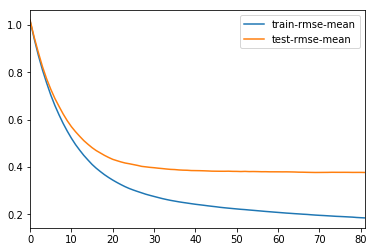

In [66]:
xgb_nestopt(xgb_model, dtrain)

Now to tune gamma value.

In [67]:
param_test2 = {
    'gamma': np.geomspace(0.001, 0.5, num=30)
}

grid_model = parameter_gs(xgb_model, param_test2)

C:\Users\Chua\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, eta=0.1,
       gamma=0.11155639876771924, i=6, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=82, n_jobs=1,
       nthread=None, objective='reg:squarederror', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=2019,
       silent=None, subsample=0.8, verbosity=1)
Optimal Params: {'gamma': 0.11155639876771924}
RMSE 0.37721591226500345


In [70]:
xgb_model.set_params(gamma = grid_model.best_params_['gamma'])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.8, eta=0.1,
       gamma=0.11155639876771924, i=6, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=82, n_jobs=1,
       nthread=None, objective='reg:squarederror', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=2019,
       silent=None, subsample=0.8, verbosity=1)

Previous RMSE: 0.35924047412204585 New RMSE: 0.3554822729561461
Previous R-squared value: 0 R-squared value: 0.8803144638125332
New model has a higher RMSE than the previous
Best Iteration: 134
train-rmse-mean    0.155039
train-rmse-std     0.005108
test-rmse-mean     0.374762
test-rmse-std      0.052493
Name: 133, dtype: float64


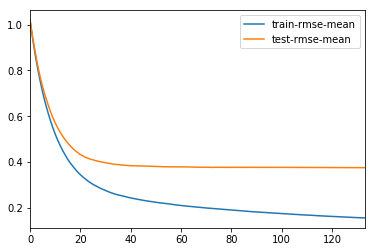

In [71]:
xgb_nestopt(xgb_model, dtrain)

Tune subsample and colsample_bytree

In [73]:
param_test3 = {
    'subsample': np.geomspace(0.9, 1, num=5),
    'colsample_bytree': np.geomspace(0.9,1, num=5)
}

grid_model = parameter_gs(xgb_model, param_test3)

C:\Users\Chua\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.9240210864723069, eta=0.1,
       gamma=0.11155639876771924, i=6, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=134, n_jobs=1,
       nthread=None, objective='reg:squarederror', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=2019,
       silent=None, subsample=1.0, verbosity=1)
Optimal Params: {'colsample_bytree': 0.9240210864723069, 'subsample': 1.0}
RMSE 0.37543198285324625


In [78]:
xgb_model.set_params(subsample=grid_model.best_params_['subsample'], colsample_bytree=grid_model.best_params_['colsample_bytree'])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.9240210864723069, eta=0.1,
       gamma=0.11155639876771924, i=6, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=134, n_jobs=1,
       nthread=None, objective='reg:squarederror', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=2019,
       silent=None, subsample=1.0, verbosity=1)

Previous RMSE: 10000000000.0 vs. New RMSE: 0.3582503340021116
Previous R-squared value: 0 vs. R-squared value: 0.8786410923400211
Best Iteration: 85
train-rmse-mean    0.183010
train-rmse-std     0.009791
test-rmse-mean     0.375367
test-rmse-std      0.055394
Name: 84, dtype: float64


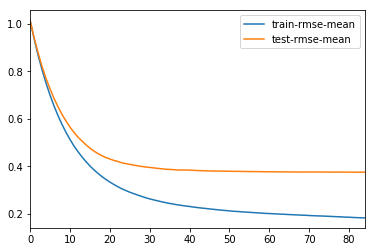

In [79]:
xgb_nestopt(xgb_model, dtrain)

Tune Regularisation Parameters. Here we will tune the l1 parameter as we found that a Lasso regression did well in our previous Linear Regression script.

In [86]:
param_test4 = {
    'reg_alpha': np.geomspace(0.01, 0.1, num=10),
}

grid_model = parameter_gs(xgb_model, param_test4)

C:\Users\Chua\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.9240210864723069, eta=0.1,
       gamma=0.11155639876771924, i=6, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=75, n_jobs=1,
       nthread=None, objective='reg:squarederror', random_state=0,
       reg_alpha=0.027825594022071243, reg_lambda=1, scale_pos_weight=1,
       seed=2019, silent=None, subsample=1.0, verbosity=1)
Optimal Params: {'reg_alpha': 0.027825594022071243}
RMSE 0.3763396607621997


In [87]:
xgb_model.set_params(reg_alpha=grid_model.best_params_['reg_alpha'])

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.9240210864723069, eta=0.1,
       gamma=0.11155639876771924, i=6, importance_type='gain',
       learning_rate=0.1, max_delta_step=0, max_depth=4,
       min_child_weight=1, missing=None, n_estimators=75, n_jobs=1,
       nthread=None, objective='reg:squarederror', random_state=0,
       reg_alpha=0.027825594022071243, reg_lambda=1, scale_pos_weight=1,
       seed=2019, silent=None, subsample=1.0, verbosity=1)

Previous RMSE: 0.3555028845041722 vs. New RMSE: 0.3533690309315935
Previous R-squared value: 0 vs. R-squared value: 0.8818370920213766
Best Iteration: 76
train-rmse-mean    0.190156
train-rmse-std     0.009052
test-rmse-mean     0.377083
test-rmse-std      0.055180
Name: 75, dtype: float64


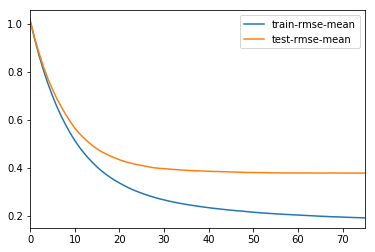

In [88]:
xgb_nestopt(xgb_model, dtrain)

Lastly, we try to Reduce the Learning Rate and add more trees (n_estimator).

C:\Users\Chua\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


Previous RMSE: 10000000000.0 vs. New RMSE: 0.35572116948290194
Previous R-squared value: 0 vs. R-squared value: 0.8808341021897331
Best Iteration: 741
train-rmse-mean    0.190940
train-rmse-std     0.009690
test-rmse-mean     0.372764
test-rmse-std      0.054195
Name: 740, dtype: float64


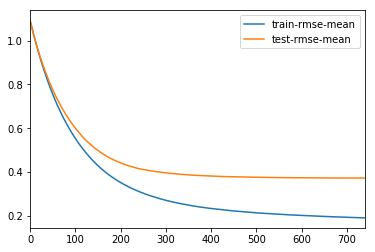

In [97]:
xgb_model.set_params(learning_rate=0.01)
xgb_nestopt(xgb_model, dtrain, num_boost=1000)

In [119]:
features = pd.Series(xgb_model.get_booster().get_fscore()).sort_values(ascending=False)

Text(0.5, 0, 'Feature Importance')

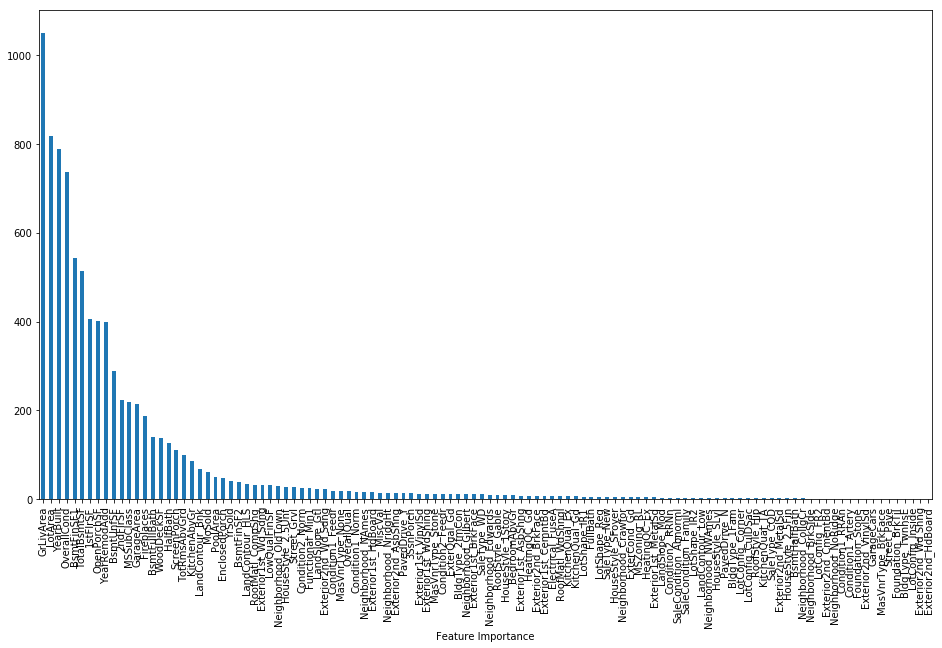

In [124]:
plt.rcParams["figure.figsize"] = [16,9]
features.plot(kind='bar')
plt.xlabel('Feature Importance')

Text(0.5, 0, 'Feature Importance')

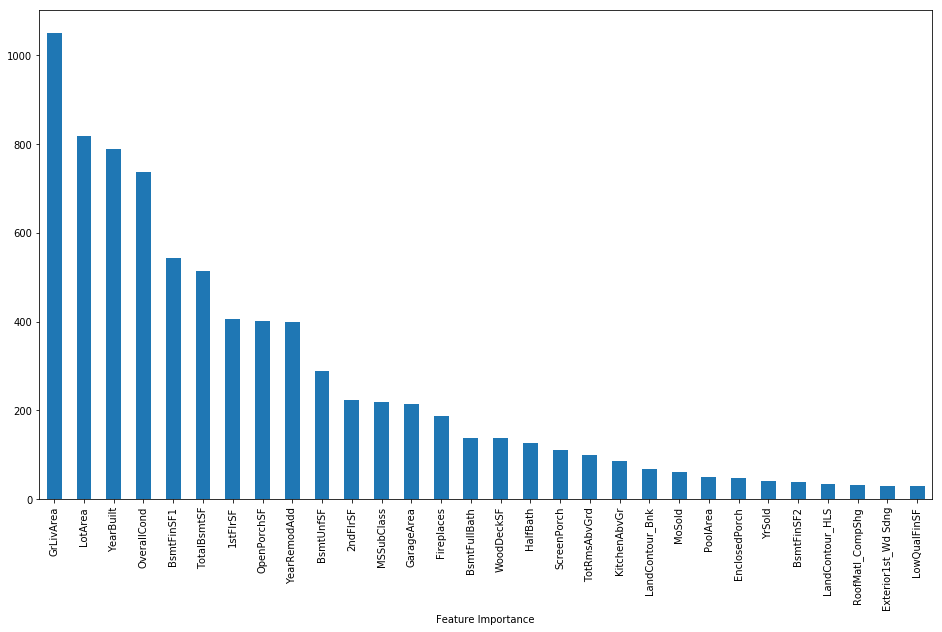

In [125]:
features[features>30].plot(kind='bar')
plt.xlabel('Feature Importance')

In [126]:
xgb_pred = xgb_model.predict(x_test)

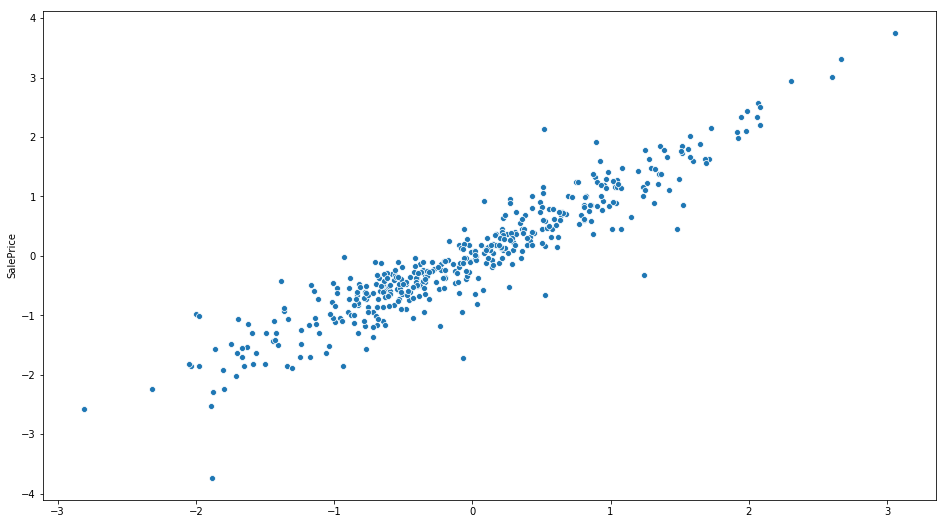

Text(0.5, 0, 'Residuals')

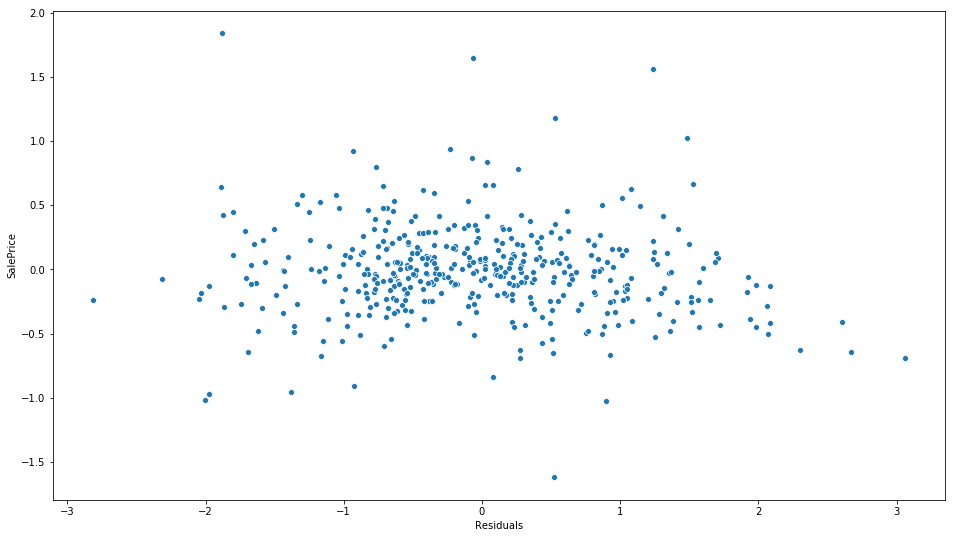

In [128]:
se.scatterplot(xgb_pred, y_test)
plt.show()
se.scatterplot(xgb_pred, xgb_pred-y_test)
plt.xlabel('Residuals')

In [129]:
print('Final RMSE:', sqrt(mean_squared_error(xgb_pred, y_test)))
print('Final R-squared value:', np.corrcoef(xgb_pred, y_test)[0][1]**2)

Final RMSE: 0.35572116948290194
Final R-squared value: 0.8808341021897331
